# Environment Setup

In [ ]:
!pwd
!pip install arrow

! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super

/content
     |████████████████████████████████| 61kB 3.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 l

In [ ]:
# NOTE: Comment below if you only run the unit tests
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

# root path for the project
rootpath = "gdrive/MyDrive/Projects/PP-Fourier-Kernel"

# key Python dependencies
import torch
import arrow
import itertools
import numpy as np
import torch.optim as optim
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

Mounted at /content/gdrive


# Proposed Model

### Kernels

In [ ]:
class ExponentialDecayingKernel(torch.nn.Module):
    """
    Exponential Decaying Kernel
    """
    def __init__(self, beta):
        """
        Arg:
        - beta: decaying rate
        """
        super(ExponentialDecayingKernel, self).__init__()
        self._beta = beta # torch.nn.Parameter(torch.rand([1]), requires_grad=True)
        # self._beta = torch.nn.Parameter(torch.rand([1]), requires_grad=True)
    
    def forward(self, x, y):
        """
        customized forward function returning kernel evaluation at x and y with 
        size [ batch_size, batch_size ], where
        - x: the first input with size  [ batch_size, data_dim ]
        - y: the second input with size [ batch_size, data_dim ] 
        """
        # return torch.nn.functional.softplus(self._beta * torch.exp(- self._beta * (x - y)))
        return self._beta * torch.exp(- self._beta * torch.abs(x - y))
        


class DeepNetworkBasis(torch.nn.Module):
    """
    Deep Neural Network Basis Kernel

    This class directly models the kernel-induced feature mapping by a deep 
    neural network.
    """
    def __init__(self, data_dim, basis_dim, 
                 init_gain=5e-1, init_bias=1e-3, nn_width=5):
        """
        Args:
        - data_dim:  dimension of input data point
        - basis_dim: dimension of basis function
        - nn_width:  the width of each layer in NN
        """
        super(DeepNetworkBasis, self).__init__()
        # configurations
        self.data_dim  = data_dim
        self.basis_dim = basis_dim
        # init parameters for net
        self.init_gain   = init_gain
        self.init_bias   = init_bias
        # network for basis function
        self.net = torch.nn.Sequential(
            torch.nn.Linear(data_dim, nn_width),  # [ data_dim, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(nn_width, nn_width),  # [ n_hidden_nodes, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(nn_width, nn_width),  # [ n_hidden_nodes, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(nn_width, basis_dim), # [ n_hidden_nodes, basis_dim ]
            torch.nn.Sigmoid())
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        """
        initialize weight matrices in network
        """
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight, gain=self.init_gain)
            m.bias.data.fill_(self.init_bias)

    def forward(self, x):
        """
        customized forward function returning basis function evaluated at x
        with size [ batch_size, data_dim ]
        """
        return self.net(x) * 2 - 1         # [ batch_size, basis_dim ]



class DeepBasisKernel(torch.nn.Module):
    """
    Deep Basis Kernel
    """
    def __init__(self, 
                 n_basis, data_dim, basis_dim, 
                 init_gain=5e-1, init_bias=1e-3, init_std=1.,
                 nn_width=5):
        """
        Arg:
        - n_basis:   number of basis functions
        - data_dim:  dimension of input data point
        - basis_dim: dimension of basis function
        - nn_width:  the width of each layer in basis NN
        """
        super(DeepBasisKernel, self).__init__()
        # configurations
        self.n_basis   = n_basis
        self.data_dim  = data_dim
        self.basis_dim = basis_dim
        # set of basis functions and corresponding weights
        self.xbasiss   = torch.nn.ModuleList([])
        self.ybasiss   = torch.nn.ModuleList([])
        self.weights   = torch.nn.ParameterList([])
        for i in range(n_basis):
            self.xbasiss.append(DeepNetworkBasis(data_dim, basis_dim, 
                                                 init_gain=init_gain, init_bias=init_bias,
                                                 nn_width=nn_width))
            self.ybasiss.append(DeepNetworkBasis(data_dim, basis_dim, 
                                                 init_gain=init_gain, init_bias=init_bias,
                                                 nn_width=nn_width))
            self.weights.append(torch.nn.Parameter(torch.empty(1).normal_(mean=0,std=init_std), requires_grad=True))
            
    def forward(self, x, y):
        """
        customized forward function returning kernel evaluation at x and y with 
        size [ batch_size, batch_size ], where
        - x: the first input with size  [ batch_size, data_dim ]
        - y: the second input with size [ batch_size, data_dim ] 
        """
        K = []
        for weight, xbasis, ybasis in zip(self.weights, self.xbasiss, self.ybasiss):
            xbasis_func = xbasis(x)                                   # [ batch_size, basis_dim ]
            ybasis_func = ybasis(y)                                   # [ batch_size, basis_dim ]
            weight      = torch.nn.functional.softplus(weight)        # scalar
            ki          = (weight * xbasis_func * ybasis_func).sum(1) # [ batch_size ]
            K.append(ki)
        K = torch.stack(K, 1).sum(1)
        return K



class SpatioTemporalDeepBasisKernel(torch.nn.Module):
    """
    Spatio-temporal Deep Basis Kernel
    """
    def __init__(self, 
                 n_basis, data_dim, basis_dim, 
                 init_gain=5e-1, init_bias=1e-3, init_std=1.,
                 nn_width=5, beta=1):
        """
        Arg:
        - n_basis:   number of basis functions
        - data_dim:  dimension of input data point
        - basis_dim: dimension of basis function
        - nn_width:  the width of each layer in basis NN
        """
        super(SpatioTemporalDeepBasisKernel, self).__init__()
        # decoupled kernels
        self.spatialkernel  = DeepBasisKernel(n_basis, data_dim-1, basis_dim, 
                                              init_gain=init_gain, init_bias=init_bias, init_std=init_std,
                                              nn_width=nn_width)
        # self.temporalkernel = ExponentialDecayingKernel(beta)
        self.beta = beta

    def temporalkernel(self, x, y):
        return self.beta * torch.exp(- self.beta * (x - y))
      
    def forward(self, x, y):
        """
        customized forward function returning kernel evaluation at x and y with 
        size [ batch_size, batch_size ], where
        - x: the first input with size  [ batch_size, data_dim ]
        - y: the second input with size [ batch_size, data_dim ] 
        """
        xt, yt = x[:, 0].clone(), y[:, 0].clone()   # [ batch_size ]
        xs, ys = x[:, 1:].clone(), y[:, 1:].clone() # [ batch_size, data_dim - 1 ]
        tval   = self.temporalkernel(xt, yt)        # [ batch_size ]
        sval   = self.spatialkernel(xs, ys)         # [ batch_size ]
        return tval * sval                          # [ batch_size ]


class DeepJointFourierSpectrum(torch.nn.Module):
    """
    Deep Joint Fourier Spectrum

    This class models the joint Fourier spectrum p(w, u), which is approximated 
    by sampling a number of fourier features from a deep neural network.
    """
    def __init__(self, noise_dim, fourier_dim, 
                 noise_mean=0, noise_std=1e+1,
                 init_gain=1e-1, init_bias=1e-3):
        """
        Args:
        - noise_dim:   dimension of input noise
        - fourier_dim: dimension of two output fourier features
        """
        super(DeepJointFourierSpectrum, self).__init__()
        # configurations
        self.noise_dim   = noise_dim
        self.fourier_dim = fourier_dim
        # noise parameters
        self.noise_mean  = noise_mean
        self.noise_std   = noise_std
        # init parameters for net
        self.init_gain   = init_gain
        self.init_bias   = init_bias
        self.net         = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 100),       # [ n_sampled_fouriers, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(100, 100),             # [ n_hidden_nodes, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(100, 100),             # [ n_hidden_nodes, n_hidden_nodes ]
            torch.nn.Softplus(), 
            torch.nn.Linear(100, fourier_dim * 2), # [ n_hidden_nodes, 2 * fourier_dim ]
            torch.nn.Sigmoid())
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        """
        initialize weight matrices in network
        """
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight, gain=self.init_gain)
            m.bias.data.fill_(self.init_bias)

    def forward(self, n_sampled_fouriers):
        """
        customized forward function returning `n_sampled_fouriers` fourier 
        features w and u.
        """
        noise    = torch.FloatTensor(n_sampled_fouriers, self.noise_dim).normal_(mean=self.noise_mean,std=self.noise_std)
        fouriers = self.net(noise) * 2 - 1                # rescale output to (-1, 1)
        ws       = fouriers[:, :self.fourier_dim].clone() # [ n_sampled_fouriers, fourier_dim ]
        us       = fouriers[:, self.fourier_dim:].clone() # [ n_sampled_fouriers, fourier_dim ]
        return ws, us



class DeepFourierKernel(torch.nn.Module):
    """
    Deep Non-Stationary Fourier Kernel k(x, y)
    """
    def __init__(self, noise_dim, data_dim):
        """
        Args:
        - noise_dim:          dimension of noise prior
        - data_dim:           dimension of input data
        """
        super(DeepFourierKernel, self).__init__()
        # configuration
        self.noise_dim   = noise_dim          # dimension of noise prior
        self.data_dim    = data_dim           # dimension of input data
        self.precomputed = False
        # fourier specturm specified by a deep neural network
        self.p  = DeepJointFourierSpectrum(self.noise_dim, self.data_dim)
        self.q  = DeepJointFourierSpectrum(self.noise_dim, self.data_dim)
        # scalar parameters
        # Note: set constant to make kernel simpler.
        self.c1 = 1e-4 # torch.nn.Parameter(torch.randn((1), requires_grad=True))
        self.c2 = 1e-4 # torch.nn.Parameter(torch.randn((1), requires_grad=True))

    def precompute_fourier_features(self, n_sampled_fouriers):
        """
        Precompute fourier features
        """
        # sampled fourier features
        self.pre_ws_p, self.pre_us_p = self.p(n_sampled_fouriers)  # 2 * [ n_sampled_fouriers, fourier_dim ]
        self.pre_ws_q, self.pre_us_q = self.q(n_sampled_fouriers)  # 2 * [ n_sampled_fouriers, fourier_dim ]
        self.precomputed = True

    def forward(self, x, y, n_sampled_fouriers=None):
        """
        return kernel evaluation at x and y with size [ batch_size, batch_size ], 
        where
        - x: the first input with size  [ batch_size, data_dim ]
        - y: the second input with size [ batch_size, data_dim ] 
        - n_sampled_fouriers: number of sampled fourier features (if None, then 
                              use precomputed fourier features)
        """
        # sampled fourier features
        if n_sampled_fouriers is not None:
            ws_p, us_p = self.p(n_sampled_fouriers)   # 2 * [ n_sampled_fouriers, fourier_dim ]
            ws_q, us_q = self.q(n_sampled_fouriers)   # 2 * [ n_sampled_fouriers, fourier_dim ]
        # use precomputed fourier features
        elif n_sampled_fouriers is None and self.precomputed is True:
            ws_p, us_p = self.pre_ws_p, self.pre_us_p # 2 * [ n_sampled_fouriers, fourier_dim ]
            ws_q, us_q = self.pre_ws_q, self.pre_us_q # 2 * [ n_sampled_fouriers, fourier_dim ]
        else:
            raise Exception("No available Fourier features.")
        # transpose
        ws_p, us_p = torch.transpose(ws_p, 0, 1), torch.transpose(us_p, 0, 1)
        ws_q, us_q = torch.transpose(ws_q, 0, 1), torch.transpose(us_q, 0, 1)
        # cosine and sine
        cos_wx_uy_p = torch.cos(torch.matmul(x, ws_p) - torch.matmul(y, us_p)) # [ batch_size, n_sampled_fouriers ]
        sin_wx_uy_q = torch.sin(torch.matmul(x, ws_q) - torch.matmul(y, us_q)) # [ batch_size, n_sampled_fouriers ]
        # integral
        eval = self.c1 * cos_wx_uy_p.mean(1) - \
               self.c2 * sin_wx_uy_q.mean(1) - \
               4 ** self.data_dim * \
               torch.prod(torch.pow(torch.sinc(x), self.data_dim)) * \
               torch.prod(torch.pow(torch.sinc(y), self.data_dim))          # [ batch_size ]

        # NOTE: currently apply softplus to prohibit negative values
        # NOTE: -0.5 to make the value smaller
        # return (torch.nn.functional.softplus(eval) - 0.5)/10 # [ batch_size ]
        return eval + 5e-5 # [ batch_size ]

# UNIT TEST
if __name__ == "__main__":
    batch_size = 16
    data_dim   = 3

    # kernel = DeepFourierKernel(noise_dim=5, data_dim=data_dim)
    # kernel.precompute_fourier_features(n_sampled_fouriers=100)
    kernel = DeepBasisKernel(n_basis=5, data_dim=data_dim, basis_dim=7)
    x      = torch.randn((batch_size, data_dim))
    y      = torch.randn((batch_size, data_dim))

    print("[%s] Unit test" % arrow.now())
    # print("[%s] input x:\n" % arrow.now(), x)
    # print("[%s] input y:\n" % arrow.now(), y)
    print("[%s] kernel(x, y):\n" % arrow.now(), kernel(x, y))

[2021-05-17T19:16:28.847321+00:00] Unit test
[2021-05-17T19:16:28.847579+00:00] kernel(x, y):
 tensor([-0.0940, -0.0880, -0.0881, -0.0857, -0.0956, -0.0900, -0.0989, -0.0817,
        -0.0935, -0.0923, -0.0961, -0.0867, -0.0938, -0.0859, -0.0851, -0.0839],
       grad_fn=<SumBackward1>)


### Point Process

In [ ]:
class BasePointProcess(torch.nn.Module):
    """
    Point Process Base Class
    """
    @abstractmethod
    def __init__(self, T, S, data_dim, numerical_int=True, int_res=100):
        """
        Args:
        - T:             time horizon. e.g. (0, 1)
        - S:             bounded space for marks. e.g. a two dimensional box region [(0, 1), (0, 1)]
        - data_dim:      dimension of input data
        - numerical_int: numerical integral flag
        - int_res:       numerical integral resolution
        """
        super(BasePointProcess, self).__init__()
        # configuration
        self.data_dim      = data_dim
        self.T             = T # time horizon. e.g. (0, 1)
        self.S             = S # bounded space for marks. e.g. a two dimensional box region [(0, 1), (0, 1)]
        self.numerical_int = numerical_int
        assert len(S) + 1 == self.data_dim, "Invalid space dimension"

        # numerical likelihood integral preparation
        if int_res is not None:
            self.int_res  = int_res
            self.tt       = torch.FloatTensor(np.linspace(self.T[0], self.T[1], int_res))  # [ in_res ]
            self.ss       = [ np.linspace(S_k[0], S_k[1], int_res) for S_k in self.S ]     # [ data_dim - 1, in_res ]
            # spatio-temporal coordinates that need to be evaluated
            self.t_coords = torch.ones((int_res ** (data_dim - 1), 1))                     # [ int_res^(data_dim - 1), 1 ]
            self.s_coords = torch.FloatTensor(np.array(list(itertools.product(*self.ss)))) # [ int_res^(data_dim - 1), data_dim - 1 ]
            # unit volumn
            self.unit_vol = np.prod([ S_k[1] - S_k[0] for S_k in self.S ] + [ self.T[1] - self.T[0] ]) / (self.int_res) ** self.data_dim

    def numerical_integral(self, X):
        """
        return conditional intensity evaluation at grid points, the numerical 
        integral can be further calculated by summing up these evaluations and 
        scaling by the unit volumn.
        """
        batch_size, seq_len, _ = X.shape
        integral = []
        for t in self.tt:
            # all possible points at time t (x_t) 
            t_coord = self.t_coords * t
            xt      = torch.cat([t_coord, self.s_coords], 1) # [ int_res^(data_dim - 1), data_dim ] 
            xt      = xt\
                .unsqueeze_(0)\
                .repeat(batch_size, 1, 1)\
                .reshape(-1, self.data_dim)                  # [ batch_size * int_res^(data_dim - 1), data_dim ]
            # history points before time t (H_t)
            mask = ((X[:, :, 0].clone() <= t) * (X[:, :, 0].clone() > 0))\
                .unsqueeze_(-1)\
                .repeat(1, 1, self.data_dim)                 # [ batch_size, seq_len, data_dim ]
            ht   = X * mask                                  # [ batch_size, seq_len, data_dim ]
            ht   = ht\
                .unsqueeze_(1)\
                .repeat(1, self.int_res ** (self.data_dim - 1), 1, 1)\
                .reshape(-1, seq_len, self.data_dim)         # [ batch_size * int_res^(data_dim - 1), seq_len, data_dim ]
            # lambda and integral 
            lams = torch.nn.functional.softplus(self.cond_lambda(xt, ht))\
                .reshape(batch_size, -1)                     # [ batch_size, int_res^(data_dim - 1) ]
            integral.append(lams)                            
        # NOTE: second dimension is time, third dimension is mark space
        integral = torch.stack(integral, 1)                  # [ batch_size, int_res, int_res^(data_dim - 1) ]
        return integral
    
    def cond_lambda(self, xi, hti):
        """
        return conditional intensity given x
        Args:
        - xi:   current i-th point       [ batch_size, data_dim ]
        - hti:  history points before ti [ batch_size, seq_len, data_dim ]
        Return:
        - lami: i-th lambda              [ batch_size ]
        """
        # if length of the history is zero
        if hti.size()[0] == 0:
            return self.mu()
        # otherwise treat zero in the time (the first) dimension as invalid points
        batch_size, seq_len, _ = hti.shape
        mask = hti[:, :, 0].clone() > 0                                          # [ batch_size, seq_len ]
        xi   = xi.unsqueeze_(1).repeat(1, seq_len, 1).reshape(-1, self.data_dim) # [ batch_size * seq_len, data_dim ]
        hti  = hti.reshape(-1, self.data_dim)                                    # [ batch_size * seq_len, data_dim ]
        K    = self.kernel(xi, hti).reshape(batch_size, seq_len)                 # [ batch_size, seq_len ]
        K    = K * mask                                                          # [ batch_size, seq_len ]
        lami = K.sum(1) + self.mu()                                              # [ batch_size ]
        return lami

    def log_likelihood(self, X, n_sampled_fouriers=200):
        """
        return log-likelihood given sequence X
        Args:
        - X:      input points sequence [ batch_size, seq_len, data_dim ]
        Return:
        - lams:   sequence of lambda    [ batch_size, seq_len ]
        - loglik: log-likelihood        [ batch_size ]
        """
        batch_size, seq_len, _ = X.shape
        lams     = [
            torch.nn.functional.softplus(self.cond_lambda(
                X[:, i, :].clone(), 
                X[:, :i, :].clone())) + 1e-5
            for i in range(seq_len) ]
        lams     = torch.stack(lams, dim=1)                                   # [ batch_size, seq_len ]
        # log-likelihood
        mask     = X[:, :, 0] > 0                                             # [ batch_size, seq_len ]
        sumlog   = torch.log(lams) * mask                                     # [ batch_size, seq_len ]
        integral = self.numerical_integral(X)                                 # [ batch_size, int_res, int_res^(data_dim - 1) ]
        if self.numerical_int:
            loglik = sumlog.sum(1) - integral.sum(-1).sum(-1) * self.unit_vol # [ batch_size ]
        else: 
            # TODO: integral in analytical form
            pass
        return lams, loglik

    @abstractmethod
    def mu(self):
        """
        return base intensity
        """
        raise NotImplementedError()

    @abstractmethod
    def forward(self, X):
        """
        custom forward function returning conditional intensities and corresponding log-likelihood
        """
        # return conditional intensities and corresponding log-likelihood
        return self.log_likelihood(X)



class ExpDecayingHawkes(BasePointProcess):
    """
    Hawkes process with exponentially decaying kernel
    """
    def __init__(self, T, S, beta, mu, data_dim, numerical_int=True, int_res=100):
        super(ExpDecayingHawkes, self).__init__(T, S, data_dim, numerical_int, int_res)
        self.kernel = ExponentialDecayingKernel(beta)
        self._mu    = mu
    
    def mu(self):
        """
        return base intensity
        """
        return self._mu


class DeepFourierPointProcess(BasePointProcess):
    """
    Point Process with Deep Fourier Kernel
    """
    def __init__(self, T, S, noise_dim, data_dim, numerical_int=True, int_res=100):
        """
        Args:
        - T:             time horizon. e.g. (0, 1)
        - S:             bounded space for marks. e.g. a two dimensional box region [(0, 1), (0, 1)]
        - noise_dim:     dimension of noise prior
        - data_dim:      dimension of input data
        - numerical_int: numerical integral flag
        - int_res:       numerical integral resolution
        """
        super(DeepFourierPointProcess, self).__init__(T, S, data_dim, numerical_int, int_res)
        # configuration
        self.noise_dim = noise_dim
        # deep fourier kernel
        self.kernel    = DeepFourierKernel(self.noise_dim, self.data_dim)
    
    def mu(self):
        """
        return base intensity
        """
        return 1.

    def forward(self, X, n_sampled_fouriers=200):
        """
        custom forward function returning conditional intensities and corresponding log-likelihood
        """
        # precompute fourier features
        self.kernel.precompute_fourier_features(n_sampled_fouriers=n_sampled_fouriers)
        # return conditional intensities and corresponding log-likelihood
        return self.log_likelihood(X)



class DeepBasisPointProcess(BasePointProcess):
    """
    Point Process with Deep NN basis
    """
    def __init__(self, 
                 T, S, mu, 
                 n_basis, basis_dim, data_dim, 
                 numerical_int=True, int_res=100, 
                 init_gain=5e-1, init_bias=1e-3, init_std=1.,
                 nn_width=5):
        """
        Args:
        - T:             time horizon. e.g. (0, 1)
        - S:             bounded space for marks. e.g. a two dimensional box region [(0, 1), (0, 1)]
        - n_basis:       number of basis functions
        - basis_dim:     dimension of basis function
        - data_dim:      dimension of input data
        - numerical_int: numerical integral flag
        - int_res:       numerical integral resolution
        - nn_width:      the width of each layer in kernel basis NN
        """
        super(DeepBasisPointProcess, self).__init__(T, S, data_dim, numerical_int, int_res)
        # configuration
        self.n_basis   = n_basis
        self.basis_dim = basis_dim
        self._mu       = mu
        # deep nn basis kernel
        self.kernel    = DeepBasisKernel(n_basis, data_dim, basis_dim, 
                                         init_gain=init_gain, init_bias=init_bias, init_std=init_std,
                                         nn_width=nn_width)
    
    def mu(self):
        """
        return base intensity
        """
        return self._mu

    def forward(self, X, n_sampled_fouriers=200):
        """
        custom forward function returning conditional intensities and corresponding log-likelihood
        """
        # return conditional intensities and corresponding log-likelihood
        return self.log_likelihood(X)



class SpatioTemporalDeepBasisPointProcess(BasePointProcess):
    """
    Spatio-temporal Point Process with Deep NN basis
    """
    def __init__(self, 
                 T, S, 
                 n_basis, basis_dim, data_dim, 
                 init_gain=5e-1, init_bias=1e-3, init_std=1.,
                 numerical_int=True, int_res=100, nn_width=5, beta=1):
        """
        See `DeepBasisPointProcess` for more details
        """
        super(SpatioTemporalDeepBasisPointProcess, self).__init__(T, S, data_dim, numerical_int, int_res)
        # configuration
        self.n_basis   = n_basis
        self.basis_dim = basis_dim
        # spatio-temporal deep nn basis kernel
        self.kernel    = SpatioTemporalDeepBasisKernel(n_basis, data_dim, basis_dim, 
                                                       init_gain=init_gain, init_bias=init_bias, init_std=init_std,
                                                       nn_width=nn_width, beta=beta)
    
    def mu(self):
        """
        return base intensity
        """
        return 1.

    def forward(self, X, n_sampled_fouriers=200):
        """
        custom forward function returning conditional intensities and corresponding log-likelihood
        """
        # return conditional intensities and corresponding log-likelihood
        return self.log_likelihood(X)
    


# # UNIT TEST
# if __name__ == "__main__":
#     T          = (0., 1.)
#     S          = ((0., 1.), (0., 1.))
#     batch_size = 2
#     data_dim   = 3
#     seq_len    = 10
#     int_res    = 20
    
#     print("[%s] Unit test" % arrow.now())

#     torch.random.manual_seed(1)
#     np.random.seed(1)
    
#     # random data preparation
#     X = np.random.uniform(low=0, high=1, size=(batch_size, seq_len, data_dim))
#     for batch_idx in range(batch_size):
#         x = X[batch_idx]           # [ seq_len, data_dim ]
#         # sort sequence by time
#         x = x[np.argsort(x[:, 0])] # [ seq_len, data_dim ]
#         X[batch_idx] = x
#     X = torch.FloatTensor(X)       # [ batch_size, seq_len, data_dim ]

#     # pp = DeepFourierPointProcess(
#     #     T=T, S=S, 
#     #     noise_dim=5, data_dim=data_dim, 
#     #     numerical_int=True, int_res=int_res)
#     pp = SpatioTemporalDeepBasisPointProcess(
#         T=T, S=S, 
#         n_basis=5, basis_dim=7, data_dim=data_dim, 
#         numerical_int=True, int_res=int_res, beta=1)

#     # test log likelihood
#     print("[%s] test log likelihood:\n" % arrow.now(), pp(X))

# Experimental Results

### 1D Synthetic Data for Hawkes

0.4
(1000, 49)


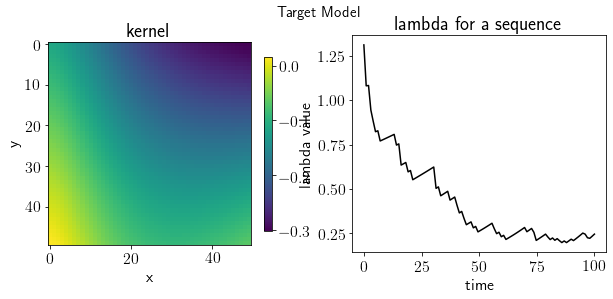

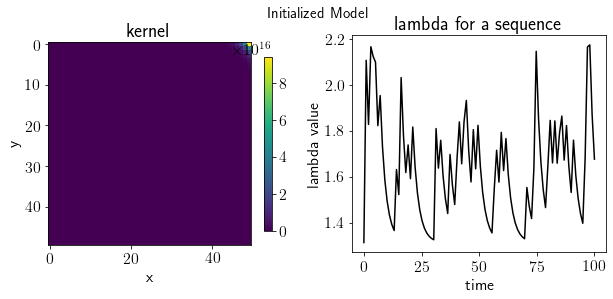

In [ ]:
def train(model,
          train_loader,
          trg_model,
          test_data,
          T, ngrid, 
          modelname="pp", 
          num_epochs=10, 
          lr=1e-4, 
          print_iter=10):
    """training procedure"""
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    plot_fitted_1D_model(model, test_data, T=T, ngrid=ngrid, filename="initialization")
    for i in range(num_epochs):
        epoch_loss = 0
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch   = data[0]
            _, loglik = model(X_batch)
            loss      = - loglik.mean()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            if j % print_iter == 0:
                print(model.kernel._beta)
                print("[%s] Epoch : %d,\titer : %d,\tloss : %.5e" % (arrow.now(), i, j, loss / print_iter))
                torch.save(model.state_dict(), "%s/saved_models/%s.pth" % (rootpath, modelname))
        
        plot_fitted_1D_model(model, test_data, T=T, ngrid=ngrid, filename="epoch %d iter %d" % (i, j))
        print("[%s] Epoch : %d,\tTotal loss : %.5e" % (arrow.now(), i, epoch_loss))

def plot_fitted_1D_model(model, points, T=(0., 1.), ngrid=1000, filename="epoch 0"):
    """
    visualize the fitted model
    """
    # calculate 1d kernel (time only) given the fitted kernel module
    def calc_1d_kernel(kernel, T, ngrid):
        t  = torch.linspace(T[0], T[1], ngrid)                          # [ ngrid ]
        tt = torch.FloatTensor(np.array(list(itertools.product(t, t)))) # [ ngrid * ngrid, 2 ]
        xx = tt[:, 0].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        yy = tt[:, 1].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals
        
    # calculate 1d point process (time only) given the fitted point process model
    def calc_1d_pointprocess(model, points, T, ngrid):
        ts      = torch.linspace(T[0], T[1], ngrid)
        lamvals = []
        for t in ts:
            t      = t.unsqueeze(0)
            his_t  = points[(points <= t) * (points > 0)]
            his_t  = his_t.unsqueeze(0).unsqueeze(-1)
            lamval = model.cond_lambda(t, his_t)
            lamval = (torch.nn.functional.softplus(lamval) + 1e-5).detach().numpy()
            lamvals.append(lamval)
        return ts, lamvals                                     # [ ngrid ]

    # plot
    kernelvals  = calc_1d_kernel(model.kernel, T, 50)
    ts, lamvals = calc_1d_pointprocess(model, points, T, ngrid)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(filename, fontsize=15)

    im = ax1.imshow(kernelvals)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    fig.colorbar(im, ax=ax1, shrink=.8)
    ax1.title.set_text('kernel')

    ax2.plot(ts, lamvals, linestyle="-", color="black")
    ax2.set_xlabel("time")
    ax2.set_ylabel("lambda value")
    ax2.title.set_text('lambda for a sequence')

    plt.show()

seed = 26
# seed = 34
torch.random.manual_seed(seed)

# training configurations
batch_size = 25
num_epochs = 50
lr         = 1e-20
modelname  = "hawkes_learned_model-%d" % seed

# model configurations
T          = (0., 100.)
S          = ()
data_dim   = 1
int_res    = 100

# define point process model
trg_model  = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, nn_width=5)
trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "deepnnbasis_target_model", seed)))

init_model = ExpDecayingHawkes(
    T=T, S=S, beta=4e-1, mu=1., data_dim=data_dim, 
    numerical_int=True, int_res=int_res)
print(init_model.kernel._beta)
# init_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

# define point process generator and generator synthetic data
data = np.load("%s/data-1d-n1000-deepnnbasis_targetmodel-%d.npy" % (rootpath, seed))
print(data.shape)

# training data preparation
data          = torch.FloatTensor(data).unsqueeze(-1)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[1].squeeze()

# visualize the target model
plot_fitted_1D_model(trg_model, test_seq, T=T, ngrid=100, filename="Target Model")
plot_fitted_1D_model(init_model, test_seq, T=T, ngrid=100, filename="Initialized Model")

# # training
# train(init_model, train_loader, trg_model=trg_model, T=T, ngrid=100, test_data=test_seq, 
#       modelname=modelname, num_epochs=num_epochs, lr=lr, print_iter=5)

### 1D Synthetic Data for Deep NN Basis PP

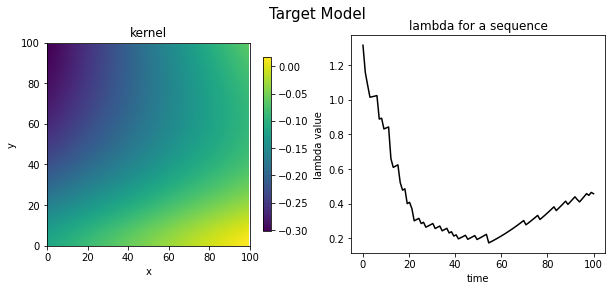

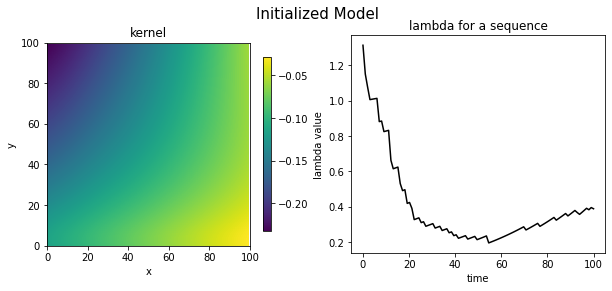

In [ ]:
def train(model,
          train_loader,
          trg_model,
          test_data,
          T, ngrid, 
          modelname="pp", 
          num_epochs=10, 
          lr=1e-4, 
          print_iter=10):
    """training procedure"""
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    plot_fitted_1D_model(model, test_data, T=T, ngrid=ngrid, filename="initialization")
    for i in range(num_epochs):
        epoch_loss = 0
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch   = data[0]
            _, loglik = model(X_batch)
            loss      = - loglik.mean()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            if j % print_iter == 0:
                print("[%s] Epoch : %d,\titer : %d,\tloss : %.5e" % (arrow.now(), i, j, loss / print_iter))
                torch.save(model.state_dict(), "%s/saved_models/%s.pth" % (rootpath, modelname))
        
        plot_fitted_1D_model(model, test_data, T=T, ngrid=ngrid, filename="epoch %d iter %d" % (i, j))
        print("[%s] Epoch : %d,\tTotal loss : %.5e" % (arrow.now(), i, epoch_loss))

def plot_fitted_1D_model(model, points, T=(0., 1.), ngrid=1000, filename="epoch 0"):
    """
    visualize the fitted model
    """
    # calculate 1d kernel (time only) given the fitted kernel module
    def calc_1d_kernel(kernel, T, ngrid):
        t  = torch.linspace(T[0], T[1], ngrid)                          # [ ngrid ]
        tt = torch.FloatTensor(np.array(list(itertools.product(t, t)))) # [ ngrid * ngrid, 2 ]
        xx = tt[:, 0].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        yy = tt[:, 1].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals
        
    # calculate 1d point process (time only) given the fitted point process model
    def calc_1d_pointprocess(model, points, T, ngrid):
        ts      = torch.linspace(T[0], T[1], ngrid)
        lamvals = []
        for t in ts:
            t      = t.unsqueeze(0)
            his_t  = points[(points <= t) * (points > 0)]
            his_t  = his_t.unsqueeze(0).unsqueeze(-1)
            lamval = model.cond_lambda(t, his_t)
            lamval = (torch.nn.functional.softplus(lamval) + 1e-5).detach().numpy()
            lamvals.append(lamval)
        return ts, lamvals                                     # [ ngrid ]

    # plot
    kernelvals  = calc_1d_kernel(model.kernel, T, ngrid)
    ts, lamvals = calc_1d_pointprocess(model, points, T, ngrid)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(filename, fontsize=15)

    im = ax1.imshow(kernelvals.transpose())
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    fig.colorbar(im, ax=ax1, shrink=.8)
    ax1.title.set_text('kernel')
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 100)

    ax2.plot(ts, lamvals, linestyle="-", color="black")
    ax2.set_xlabel("time")
    ax2.set_ylabel("lambda value")
    ax2.title.set_text('lambda for a sequence')

    plt.show()

seed = 26
# seed = 18
torch.random.manual_seed(seed)

# training configurations
batch_size = 25
num_epochs = 50
lr         = 1e-3
modelname  = "deepnnbasis_learned_model-%d" % seed

# model configurations
T          = (0., 100.)
S          = ()
data_dim   = 1
int_res    = 100

# define point process model
trg_model  = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=5e-1, init_bias=-1e-1, init_std=1,
    nn_width=5)
# torch.save(trg_model.state_dict(), "%s/saved_models/%s-%d.pth" % (rootpath, "deepnnbasis_target_model", seed))
trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "deepnnbasis_target_model", seed)))

init_model = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=5e-1, init_bias=-1e-1, init_std=1,
    nn_width=10)
init_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

# define point process generator and generator synthetic data
# generator  = TemporalPointProcessGenerator(trg_model, upper_bound=1e+2)
# data, size = generator.generate(T=T, batch_size=1000, min_n_points=5, verbose=True)
# np.save("%s/data-1d-n1000-deepnnbasis_targetmodel-%d.npy" % (rootpath, seed), data)
data = np.load("%s/data-1d-n1000-deepnnbasis_targetmodel-%d.npy" % (rootpath, seed))
# print(data.shape)

# training data preparation
data          = torch.FloatTensor(data).unsqueeze(-1)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[0].squeeze()

# visualize the target model
plot_fitted_1D_model(trg_model, test_seq, T=T, ngrid=100, filename="Target Model")
plot_fitted_1D_model(init_model, test_seq, T=T, ngrid=100, filename="Initialized Model")

# # training
# train(init_model, train_loader, trg_model=trg_model, T=T, ngrid=100, test_data=test_seq, 
#       modelname=modelname, num_epochs=num_epochs, lr=lr, print_iter=5)

### 2D Synthetic Data for Deep NN Basis PP

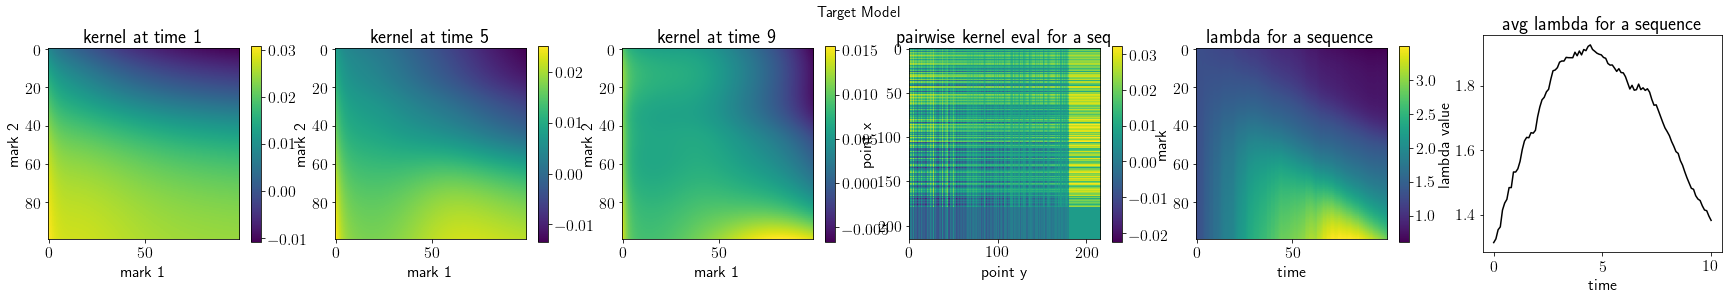

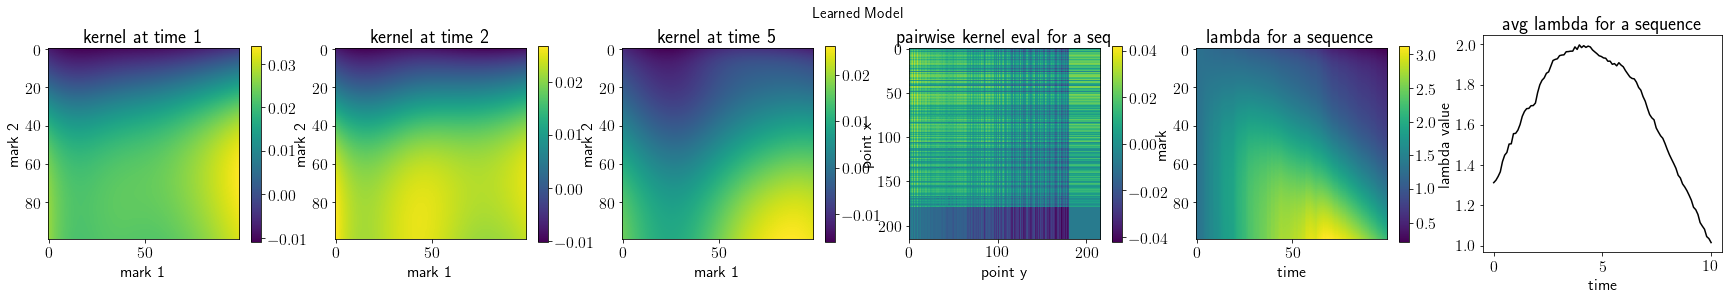

In [ ]:
def train(model,
          train_loader,
          trg_model,
          test_data,
          ts, T, S, ngrid, 
          modelname="pp", 
          num_epochs=10, 
          lr=1e-4, 
          print_iter=10):
    """training procedure"""
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    plot_fitted_2D_model(model, test_data, ts=ts, T=T, S=S, ngrid=ngrid, filename="initialization")

    for i in range(num_epochs):
        epoch_loss = 0
        for j, data in enumerate(train_loader):

            optimizer.zero_grad()
            X_batch   = data[0]
            _, loglik = model(X_batch)
            loss      = - loglik.mean()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            if j % print_iter == 0:
                print("[%s] Epoch : %d,\titer : %d,\tloss : %.5e" % (arrow.now(), i, j, loss / print_iter))
                torch.save(model.state_dict(), "%s/saved_models/%s.pth" % (rootpath, modelname))
        
        plot_fitted_2D_model(model, test_data, ts=ts, T=T, S=S, ngrid=ngrid, filename="epoch %d iter %d" % (i, j))
        print("[%s] Epoch : %d,\tTotal loss : %.5e" % (arrow.now(), i, epoch_loss))

def plot_fitted_2D_model(model, points, 
                         ts=[10, 50, 80], 
                         T=(0., 100.),
                         S=(0., 100.), 
                         ngrid=1000, filename="epoch 0"):
    """
    visualize the fitted model
    """
    # calculate 2d kernel (time only) given the fitted kernel module and one of its input
    def calc_2d_kernel(kernel, t, S, ngrid):
        tt = torch.FloatTensor([t]).unsqueeze(0).repeat(ngrid**2, 1)    # [ ngrid^2, 1 ]
        s  = np.linspace(S[0], S[1], ngrid)                             # [ ngrid ] 
        ss = torch.FloatTensor(np.array(list(itertools.product(s, s)))) # [ ngrid^2, 2 ] 
        xx = torch.cat([tt, ss[:, [0]]], 1)                             # [ ngrid^2, 2 ]
        yy = torch.cat([tt, ss[:, [1]]], 1)                             # [ ngrid^2, 2 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals
        
    # calculate 2d point process (time only) given the fitted point process model
    def calc_2d_pointprocess(model, points, T, ngrid):
        ts      = torch.linspace(T[0], T[1], ngrid)
        lamvals = []
        for t in ts:
            _t     = t.unsqueeze(0).repeat(ngrid, 1)                    # [ ngrid, 1 ]
            s      = torch.linspace(S[0], S[1], ngrid).unsqueeze(1)     # [ ngrid, 1 ]
            x      = torch.cat([_t, s], 1)                              # [ ngrid, 2 ]
            ind    = np.where((points[:, 0] <= t) & (points[:, 0] > 0))[0]
            his_x  = points[ind, :]                                     # [ seq_len, 2 ]
            his_x  = his_x.unsqueeze(0).repeat(ngrid, 1, 1)             # [ ngrid, seq_len, 2 ]
            lamval = model.cond_lambda(x, his_x)                        # [ ngrid ]
            lamval = lamval                                             # [ ngrid ]
            lamval = (torch.nn.functional.softplus(lamval) + 1e-5).detach().numpy()
            lamvals.append(lamval)
        lamvals = np.stack(lamvals, 0)                                  # [ ngrid, ngrid ]
        return ts, lamvals  

    def calc_pairwise_kernel(kernel, points):
        xx, yy = [], []
        for i in range(len(points)):
            for j in range(len(points)):
                xx.append(points[i, :])
                yy.append(points[j, :])
        xx   = torch.stack(xx, 0)                                       # [ seq_len^2, 2 ]
        yy   = torch.stack(yy, 0)                                       # [ seq_len^2, 2 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ] 
        vals = vals.reshape(len(points), len(points)).detach().numpy()  # [ seq_len, seq_len ]
        return vals                   

    # plot
    kernelvals     = []
    for t in ts:
        kernelval  = calc_2d_kernel(model.kernel, t, S, ngrid)
        kernelvals.append(kernelval)
    pairkernelvals = calc_pairwise_kernel(model.kernel, points)
    tt, lamvals    = calc_2d_pointprocess(model, points, T, ngrid)
    avglamvals     = lamvals.mean(1)

    fig, handles = plt.subplots(1, len(ts)+3, figsize=(5 * (len(ts)+3), 4))
    fig.suptitle(filename, fontsize=15)

    for i, ax in enumerate(handles[:len(ts)]):
        imi = ax.imshow(kernelvals[i])
        ax.set_xlabel("mark 1")
        ax.set_ylabel("mark 2")
        fig.colorbar(imi, ax=ax, shrink=.9)
        ax.title.set_text('kernel at time %d' % ts[i])

    ax = handles[-3]
    imi = ax.imshow(pairkernelvals)
    ax.set_xlabel("point y")
    ax.set_ylabel("point x")
    fig.colorbar(imi, ax=ax, shrink=.9)
    ax.title.set_text('pairwise kernel eval for a seq')

    ax = handles[-2]
    imi = ax.imshow(lamvals.transpose())
    ax.set_xlabel("time")
    ax.set_ylabel("mark")
    fig.colorbar(imi, ax=ax, shrink=.9)
    ax.title.set_text('lambda for a sequence')

    ax = handles[-1]
    ax.plot(tt, avglamvals, linestyle="-", color="black")
    ax.set_xlabel("time")
    ax.set_ylabel("lambda value")
    ax.title.set_text('avg lambda for a sequence')
    plt.show()

# seed = 1234 # kernel values are too small to learn
seed = 3 # divided by 1e+2 (1e+1 for other seeds)
torch.random.manual_seed(seed)

# training configurations
batch_size = 50
num_epochs = 20
lr         = 1e-2
modelname  = "marktemporal-deepnnbasis_learned_model-%d" % seed

# model configurations
T          = (0., 10.)
S          = [(0., 10.)]
data_dim   = 2
int_res    = 20

# define point process model
trg_model  = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=10, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=1.5e+0, init_bias=0, init_std=1,
    nn_width=5)
# torch.save(trg_model.state_dict(), "%s/saved_models/%s-%d.pth" % (rootpath, "marktemporal-deepnnbasis_target_model", seed))
# trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "marktemporal-deepnnbasis_target_model", seed)))

init_model = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=10, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=1.5e+0, init_bias=0, init_std=1,
    nn_width=10)
init_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

# define point process generator and generator synthetic data
# generator  = SpatioTemporalPointProcessGenerator(trg_model, upper_bound=1e+2, T=T, S=S)
# data, size = generator.generate(batch_size=1000, min_n_points=5, verbose=True)
# np.save("%s/data-2d-n1000-marktemporal-deepnnbasis_target_model-%d.npy" % (rootpath, seed), data)
data = np.load("%s/data-2d-n1000-marktemporal-deepnnbasis_target_model-%d.npy" % (rootpath, seed))

# training data preparation
data          = torch.FloatTensor(data)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[0].squeeze()

# visualize the target model
plot_fitted_2D_model(trg_model, test_seq, ts=[1, 5, 9], T=T, S=S[0], ngrid=100, filename="Target Model")
plot_fitted_2D_model(init_model, test_seq, ts=[1, 2, 5], T=T, S=S[0], ngrid=100, filename="Learned Model")

# # training
# train(init_model, train_loader, trg_model=trg_model, ts=[1, 2, 3], T=T, S=S[0], ngrid=50, test_data=test_seq, 
#       modelname=modelname, num_epochs=num_epochs, lr=lr, print_iter=5)

### 3D Synthetic Data for Deep NN Basis PP

(1000, 209, 3)


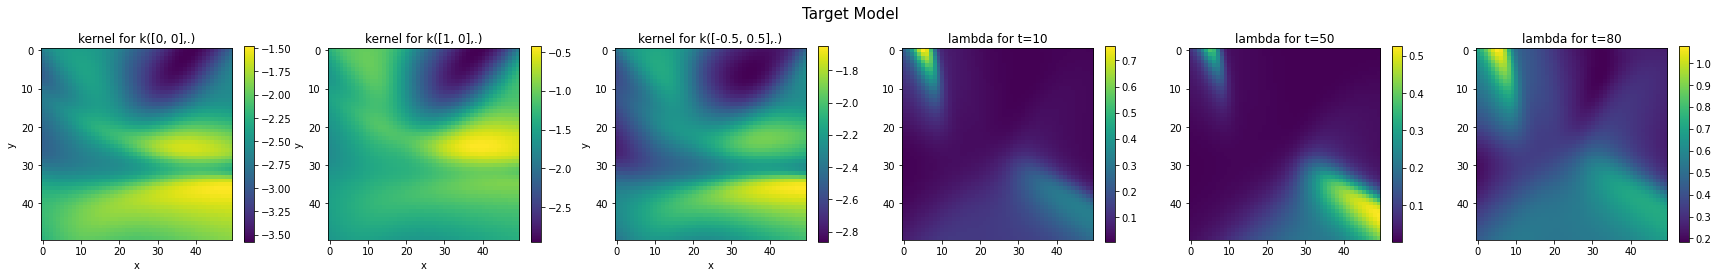

In [ ]:
def train(model,
          train_loader,
          trg_model,
          test_data,
          S, ngrid, 
          modelname="pp", 
          num_epochs=10, 
          lr=1e-4, 
          print_iter=10):
    """training procedure"""
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    plot_fitted_2D_model(model, test_data, S=S, ngrid=ngrid, filename="initialization")

    for i in range(num_epochs):
        epoch_loss = 0
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch   = data[0]
            _, loglik = model(X_batch)
            loss      = - loglik.mean()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            if j % print_iter == 0:
                print("[%s] Epoch : %d,\titer : %d,\tloss : %.5e" % (arrow.now(), i, j, loss / print_iter))
                torch.save(model.state_dict(), "%s/saved_models/%s.pth" % (rootpath, modelname))
        
        plot_fitted_2D_model(model, test_data, S=S, ngrid=ngrid, filename="epoch %d iter %d" % (i, j))
        print("[%s] Epoch : %d,\tTotal loss : %.5e" % (arrow.now(), i, epoch_loss))

def plot_fitted_2D_model(model, points, 
                         ss=[[0, 0], [1, 0], [-0.5, 0.5]], 
                         ts=[10, 50, 80], 
                         S=[(-1., 1.), (-1., 1.)], 
                         ngrid=1000, filename="epoch 0"):
    """
    visualize the fitted model
    """
    # calculate 2d kernel (time only) given the fitted kernel module and one of its input
    def calc_2d_kernel(kernel, t, s, S, ngrid):
        tt = torch.FloatTensor([t]).unsqueeze(0).repeat(ngrid**2, 1)  # [ ngrid^(data_dim - 1), 1 ]
        xs = s.unsqueeze(0).repeat(ngrid**2, 1)                       # [ ngrid^(data_dim - 1), data_dim - 1 ]
        s  = [ np.linspace(S_k[0], S_k[1], ngrid) for S_k in S ]      # [ data_dim - 1, ngrid ] e.g. (2, 100)
        ys = torch.FloatTensor(np.array(list(itertools.product(*s)))) # [ ngrid^(data_dim - 1), data_dim - 1 ] e.g. (100^2, 2)
        xx = torch.cat([tt, xs], 1)
        yy = torch.cat([tt, ys], 1)
        vals = kernel(xx, yy)                                         # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()            # [ ngrid, ngrid ]
        return vals
        
    # calculate 1d point process (time only) given the fitted point process model
    def calc_3d_pointprocess(model, points, t, ngrid):
        tt = torch.FloatTensor([t]).unsqueeze(0).repeat(ngrid**2, 1)  # [ ngrid^(data_dim - 1), 1 ] e.g. (100^2, 1)
        s  = [ np.linspace(S_k[0], S_k[1], ngrid) for S_k in S ]      # [ data_dim - 1, ngrid ] e.g. (2, 100)
        ss = torch.FloatTensor(np.array(list(itertools.product(*s)))) # [ ngrid^(data_dim - 1), data_dim - 1 ] e.g. (100^2, 2)
        xx = torch.cat([tt, ss], 1)                                   # [ ngrid^(data_dim - 1), data_dim ] e.g. (100^2, 3)
        his_xx = points.unsqueeze(0).repeat(ngrid**2, 1, 1)           # [ ngrid^(data_dim - 1), seq_len, data_dim ] e.g. (100^2, seq_len, 3)
        lamval = model.cond_lambda(xx, his_xx)                        # [ ngrid^(data_dim - 1) ]
        lamval = lamval.view([ngrid, ngrid])                          # [ ngrid, ngrid ]
        lamval = torch.nn.functional.softplus(lamval).detach().numpy()
        return lamval                                     

    # plot
    kernelvals    = []
    for t, s in zip(ts, ss):
        s         = torch.FloatTensor(s)
        kernelval = calc_2d_kernel(model.kernel, t, s, S, ngrid)
        kernelvals.append(kernelval)
    lamvals    = []
    for t in ts:
        mask   = points[:, 0] < t
        his_x  = points[mask, :]
        lamval = calc_3d_pointprocess(model, his_x, t, ngrid)
        lamvals.append(lamval)

    fig, handles = plt.subplots(1, len(ts)+len(ss), figsize=(5 * (len(ts)+len(ss)), 4))
    fig.suptitle(filename, fontsize=15)

    for i, ax in enumerate(handles[:len(ss)]):
        imi = ax.imshow(kernelvals[i])
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(imi, ax=ax, shrink=.9)
        ax.title.set_text('kernel for k(%s,.)' % ss[i])

    for i, ax in enumerate(handles[len(ss):]):
        imi = ax.imshow(lamvals[i])
        fig.colorbar(imi, ax=ax, shrink=.9)
        ax.title.set_text('lambda for t=%d' % ts[i])

    plt.show()

seed = 5
torch.random.manual_seed(seed)

# training configurations
batch_size = 25
num_epochs = 50
lr         = 1e-2
modelname  = "spatiotemporal-1layernnbasis_learned_model-%d" % seed

# model configurations
T          = (0., 100.)
S          = ((-1, 1), (-1, 1))
data_dim   = 3
int_res    = 10

# define point process model
trg_model  = SpatioTemporalDeepBasisPointProcess(
    T=T, S=S, 
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    # init_gain=3.5e+0, init_bias=-7e-1,
    init_gain=3e+0, init_bias=-1e-1,
    nn_width=5, beta=1)
torch.save(trg_model.state_dict(), "%s/saved_models/%s-%d.pth" % (rootpath, "spatiotemporal-deepnnbasis_target_model", seed))
trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "spatiotemporal-deepnnbasis_target_model", seed)))

init_model = DeepBasisPointProcess(
    T=T, S=S, 
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    nn_width=10)
# init_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

# define point process generator and generator synthetic data
# generator  = SpatioTemporalPointProcessGenerator(trg_model, upper_bound=1e+2)
# data, size = generator.generate(T=T, batch_size=1000, min_n_points=5, verbose=True)
# np.save("%s/data-3d-n1000-spatiotemporal-1layernnbasis_targetmodel-%d.npy" % (rootpath, seed), data)
data = np.load("%s/data-3d-n1000-spatiotemporal-1layernnbasis_targetmodel-%d.npy" % (rootpath, seed))
print(data.shape)

# training data preparation
data          = torch.FloatTensor(data)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[0].squeeze()

# visualize the target model
plot_fitted_2D_model(trg_model, test_seq, 
                     ss=[[0, 0], [1, 0], [-0.5, 0.5]], 
                     ts=[10, 50, 80], 
                     S=S, ngrid=50, filename="Target Model")
# plot_fitted_2D_model(init_model, test_seq, 
#                      xs=[[0, 0], [1, 0], [-0.5, 0.5]], 
#                      ts=[10, 50, 80], 
#                      S=S, ngrid=50, filename="Initialized Model")

# # training
# train(init_model, train_loader, trg_model=trg_model, S=S, ngrid=50, test_data=test_seq, 
#       modelname=modelname, num_epochs=num_epochs, lr=lr, print_iter=5)

### Visualization

In [ ]:
import matplotlib.ticker as ticker

def plot_fitted_2D_model(model, points, 
                         ts=[1, 2, 3], ms=[1],
                         T=(0., 100.),
                         S=(0., 100.), 
                         ngrid=1000, filename="epoch 0"):
    """
    visualize the fitted model
    reference: https://learnsharewithdp.wordpress.com/2020/05/08/latex-matplotlib-google-colab/
    """
    # calculate 2d kernel (in mark space) given the fitted kernel module and one of its input
    def calc_2d_mark_kernel(kernel, t, S, ngrid):
        tt = torch.FloatTensor([t]).unsqueeze(0).repeat(ngrid**2, 1)    # [ ngrid^2, 1 ]
        s  = torch.linspace(S[0], S[1], ngrid)                          # [ ngrid ] 
        ss = torch.FloatTensor(np.array(list(itertools.product(s, s)))) # [ ngrid^2, 2 ] 
        xx = torch.cat([tt, ss[:, [0]]], 1)                             # [ ngrid^2, 2 ]
        yy = torch.cat([tt, ss[:, [1]]], 1)                             # [ ngrid^2, 2 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals

    # calculate 2d kernel (in time space) given the fitted kernel module and one of its input
    def calc_2d_time_kernel(kernel, s, T, ngrid):
        ss = torch.FloatTensor([s]).unsqueeze(0).repeat(ngrid**2, 1)    # [ ngrid^2, 1 ]
        t  = torch.linspace(T[0], T[1], ngrid)                          # [ ngrid ] 
        tt = torch.FloatTensor(np.array(list(itertools.product(t, t)))) # [ ngrid^2, 2 ] 
        xx = torch.cat([tt[:, [0]], ss], 1)                             # [ ngrid^2, 2 ]
        yy = torch.cat([tt[:, [1]], ss], 1)                             # [ ngrid^2, 2 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals
        
    # calculate 2d point process (time only) given the fitted point process model
    def calc_2d_pointprocess(model, points, T, ngrid):
        ts      = torch.linspace(T[0], T[1], ngrid)
        lamvals = []
        for t in ts:
            _t     = t.unsqueeze(0).repeat(ngrid, 1)                    # [ ngrid, 1 ]
            s      = torch.linspace(S[0], S[1], ngrid).unsqueeze(1)     # [ ngrid, 1 ]
            x      = torch.cat([_t, s], 1)                              # [ ngrid, 2 ]
            ind    = np.where((points[:, 0] <= t) & (points[:, 0] > 0))[0]
            his_x  = points[ind, :]                                     # [ seq_len, 2 ]
            his_x  = his_x.unsqueeze(0).repeat(ngrid, 1, 1)             # [ ngrid, seq_len, 2 ]
            lamval = model.cond_lambda(x, his_x)                        # [ ngrid ]
            lamval = lamval                                             # [ ngrid ]
            lamval = (torch.nn.functional.softplus(lamval) + 1e-5).detach().numpy()
            lamvals.append(lamval)
        lamvals = np.stack(lamvals, 0)                                  # [ ngrid, ngrid ]
        return ts, lamvals  

    def calc_pairwise_kernel(kernel, points):
        xx, yy = [], []
        for i in range(len(points)):
            for j in range(len(points)):
                xx.append(points[i, :])
                yy.append(points[j, :])
        xx   = torch.stack(xx, 0)                                       # [ seq_len^2, 2 ]
        yy   = torch.stack(yy, 0)                                       # [ seq_len^2, 2 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ] 
        vals = vals.reshape(len(points), len(points)).detach().numpy()  # [ seq_len, seq_len ]
        return vals        

    def fmt(x, pos):
        return "%.1e" % x

    # plot
    mkernelvals    = []
    tkernelvals    = []
    for _t in ts:
        mkernelval = calc_2d_mark_kernel(model.kernel, _t, S, ngrid)
        mkernelvals.append(mkernelval)
    for _m in ms:
        tkernelval = calc_2d_time_kernel(model.kernel, _m, T, ngrid)
        tkernelvals.append(tkernelval)
    tt, lamvals    = calc_2d_pointprocess(model, points, T, ngrid)

    font = {
        'family' : 'sans-serif',
        'size'   : 16}
    plt.rc('font', **font)  
    plt.rc('text', usetex=True)

    fig, handles = plt.subplots(1, len(ts)+len(ms)+1, figsize=(5 * (len(ts)+len(ms)+1), 4))

    for i, ax in enumerate(handles[:len(ts)]):
        imi = ax.imshow(mkernelvals[i].transpose())
        ax.set_xlabel(r"Mark $m$")
        ax.set_ylabel(r"Mark $m'$")
        ax.set_xticks([])
        ax.set_yticks([])
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        fig.colorbar(imi, ax=ax, shrink=.95, format=ticker.FuncFormatter(fmt))
        ax.set_title(r"Kernel $k(t, t, m, m')$ (t = %d)" % ts[i], pad=15)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
    
    for i, ax in enumerate(handles[len(ts):len(ts)+len(ms)]):
        imi = ax.imshow(tkernelvals[i].transpose())
        ax.set_xlabel(r"Time $t$")
        ax.set_ylabel(r"Time $t'$")
        ax.set_xticks([])
        ax.set_yticks([])
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        fig.colorbar(imi, ax=ax, shrink=.95, format=ticker.FuncFormatter(fmt))
        ax.set_title(r"Kernel $k(t, t', m, m)$ (m = %d)" % ms[i], pad=15)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)

    ax = handles[-1]
    imi = ax.imshow(lamvals.transpose(), cmap=plt.cm.cool_r)
    ax.scatter(points[:, 0] * 10, points[:, 1] * 10, c="black", marker="*", s=10)
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel(r"Mark $m$")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    fig.colorbar(imi, ax=ax, shrink=.95, format=ticker.FuncFormatter(fmt))
    ax.set_title(r'Conditional intensity $\lambda$', pad=15)

    plt.figtext(-.02, .3, filename, rotation=90, fontsize=21)
    fig.tight_layout()
    plt.show()

def plot_fitted_1D_model(trg_model, lrn_model, hwk_model, points, T=(0., 1.), ngrid=100, filename="epoch 0"):
    """
    visualize the fitted model
    """
    # calculate 1d kernel (time only) given the fitted kernel module
    def calc_1d_kernel(kernel, T, ngrid):
        t  = torch.linspace(T[0], T[1], ngrid)                          # [ ngrid ]
        tt = torch.FloatTensor(np.array(list(itertools.product(t, t)))) # [ ngrid * ngrid, 2 ]
        xx = tt[:, 0].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        yy = tt[:, 1].clone().unsqueeze(-1)                             # [ ngrid * ngrid, 1 ]
        vals = kernel(xx, yy)                                           # [ ngrid * ngrid ]
        vals = vals.reshape(ngrid, ngrid).detach().numpy()              # [ ngrid, ngrid ]
        return vals
        
    # calculate 1d point process (time only) given the fitted point process model
    def calc_1d_pointprocess(model, points, T, ngrid):
        ts      = torch.linspace(T[0], T[1], ngrid)
        lamvals = []
        for t in ts:
            t      = t.unsqueeze(0)
            his_t  = points[(points <= t) * (points > 0)]
            his_t  = his_t.unsqueeze(0).unsqueeze(-1)
            lamval = model.cond_lambda(t, his_t)
            lamval = (torch.nn.functional.softplus(lamval) + 1e-5).detach().numpy()
            lamvals.append(lamval)
        return ts, lamvals                                     # [ ngrid ]

    def fmt(x, pos):
        return "%.1e" % x

    # plot
    trg_kernelvals  = calc_1d_kernel(trg_model.kernel, T, ngrid)
    ts, trg_lamvals = calc_1d_pointprocess(trg_model, points, T, ngrid * 2)

    lrn_kernelvals  = calc_1d_kernel(lrn_model.kernel, T, ngrid)
    ts, lrn_lamvals = calc_1d_pointprocess(lrn_model, points, T, ngrid * 2)

    hwk_kernelvals  = calc_1d_kernel(hwk_model.kernel, T, ngrid)
    ts, hwk_lamvals = calc_1d_pointprocess(hwk_model, points, T, ngrid * 2)

    font = {
        'family' : 'sans-serif',
        'size'   : 20}
    plt.rc('font', **font)  
    plt.rc('text', usetex=True)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    # fig.suptitle(filename, fontsize=15)

    # im = ax1.imshow(trg_kernelvals.transpose(), vmin=-6e-2, vmax=1.5e-2) # seed=18
    im = ax1.imshow(trg_kernelvals.transpose(), vmin=-1.5e-2, vmax=.5e-2) # seed=26
    # im = ax1.imshow(trg_kernelvals.transpose(), vmin=4e-3, vmax=1.5e-2) # seed=34
    ax1.set_xlabel(r"Time $t$")
    ax1.set_ylabel(r"Time $t'$")
    ax1.set_xticks([])
    ax1.set_yticks([])
    fig.colorbar(im, ax=ax1, shrink=.9, format=ticker.FuncFormatter(fmt))
    ax1.set_title(r"True Kernel $k(t, t')$", pad=15)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(2)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 100)

    # im = ax2.imshow(lrn_kernelvals.transpose(), vmin=-6e-2, vmax=1.5e-2) # seed=18
    im = ax2.imshow(lrn_kernelvals.transpose(), vmin=-1.5e-2, vmax=.5e-2) # seed=26
    # im = ax2.imshow(lrn_kernelvals.transpose(), vmin=4e-3, vmax=1.5e-2) # seed=34
    ax2.set_xlabel(r"Time $t$")
    ax2.set_ylabel(r"Time $t'$")
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.colorbar(im, ax=ax2, shrink=.9, format=ticker.FuncFormatter(fmt))
    ax2.set_title(r"Proposed Kernel $\hat k(t, t')$", pad=15)
    for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(2)
    ax2.set_xlim(0, 100)
    ax2.set_ylim(0, 100)

    im = ax3.imshow(np.log(hwk_kernelvals.transpose() + 1e-5))
    ax3.set_xlabel(r"Time $t$")
    ax3.set_ylabel(r"Time $t'$")
    ax3.set_xticks([])
    ax3.set_yticks([])
    cbar = fig.colorbar(im, ax=ax3, shrink=.9, format=ticker.FuncFormatter(fmt))
    cbar.set_label('in log scale')
    ax3.set_title(r"Stationary Kernel", pad=15)
    for axis in ['top','bottom','left','right']:
        ax3.spines[axis].set_linewidth(2)    
    ax3.set_xlim(0, 100)
    ax3.set_ylim(0, 100)

    ax4.plot(ts, trg_lamvals, linestyle="-", color="black", label="True")
    ax4.plot(ts, lrn_lamvals, linestyle="-", color="red", label="Proposed")
    ax4.plot(ts, hwk_lamvals, linestyle=":", color="gray", label="Stationary")
    ax4.set_xlabel(r"Time $t$")
    ax4.set_ylabel(r"$\lambda(t)$")
    ax4.set_title(r"Conditional intensity $\lambda$", pad=15)
    ax4.set_xticks([])
    asp = np.diff(ax4.get_xlim())[0] / np.diff(ax4.get_ylim())[0]
    asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax4.set_aspect(asp)
    legend = ax4.legend(loc="upper left", framealpha=0.5)
    for axis in ['top','bottom','left','right']:
        ax4.spines[axis].set_linewidth(2)

    plt.figtext(-.02, .3, filename, rotation=90, fontsize=21)

    fig.tight_layout(pad=.1)
    plt.show()  

### 1D

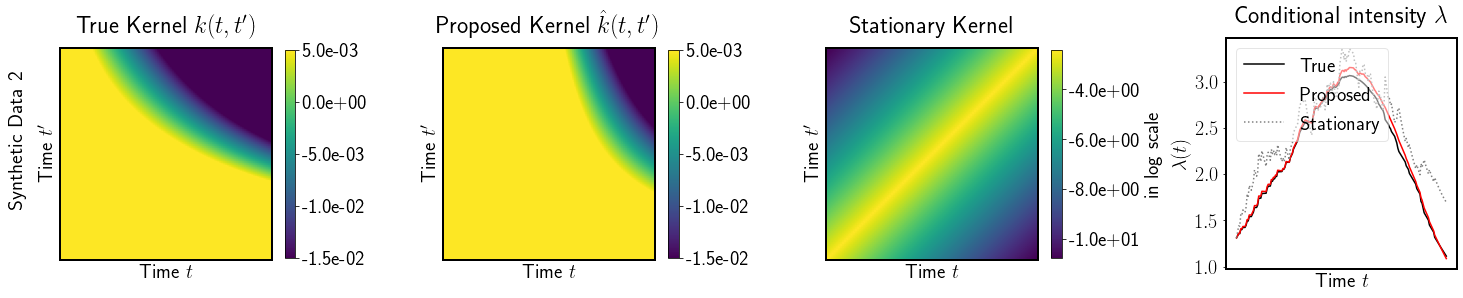

In [ ]:
# seed = 34
# seed = 26
seed = 18
torch.random.manual_seed(seed)

# training configurations
batch_size = 25
num_epochs = 50
lr         = 1e-2
modelname  = "deepnnbasis_learned_model-%d" % seed

# model configurations
T          = (0., 100.)
S          = ()
data_dim   = 1
int_res    = 100

# define point process model
trg_model  = DeepBasisPointProcess(
    T=T, S=S, mu=1,
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, nn_width=5)
trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "deepnnbasis_target_model", seed)))

init_model = DeepBasisPointProcess(
    T=T, S=S, mu=1,
    n_basis=5, basis_dim=7, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, nn_width=10)
init_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

hawk_model = ExpDecayingHawkes(
    T=T, S=S, beta=.9e-1, mu=1, data_dim=data_dim, # seed = 18
    # T=T, S=S, beta=.4e-2, mu=1, data_dim=data_dim, # seed = 26
    # T=T, S=S, beta=.25e-1, mu=1, data_dim=data_dim, # seed = 34
    numerical_int=True, int_res=int_res)

data = np.load("%s/data-1d-n1000-deepnnbasis_targetmodel-%d.npy" % (rootpath, seed))

# training data preparation
data          = torch.FloatTensor(data).unsqueeze(-1)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[0].squeeze()

# visualize the target model
plot_fitted_1D_model(trg_model, init_model, hawk_model, test_seq, T=T, ngrid=100, filename="Synthetic Data 2")
# plot_fitted_1D_model(trg_model, test_seq, T=T, ngrid=100, filename="Target Model")
# plot_fitted_1D_model(init_model, test_seq, T=T, ngrid=100, filename="Initialized Model")

### 2D

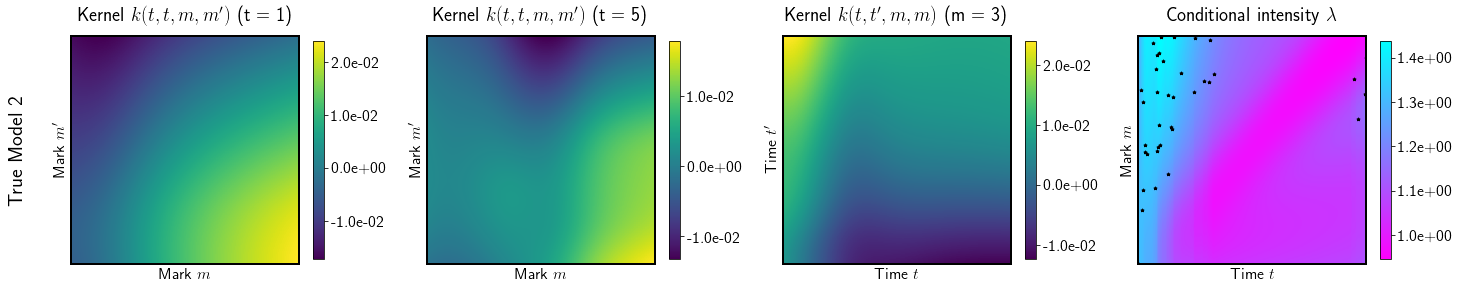

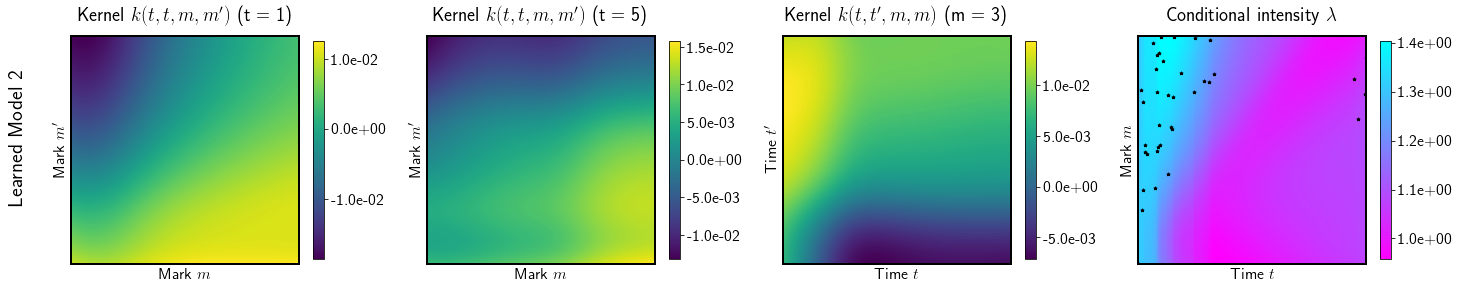

In [ ]:
# model configurations
seed       = 5
T          = (0., 10.)
S          = [(0., 10.)]
data_dim   = 2
int_res    = 20
modelname  = "marktemporal-deepnnbasis_learned_model-%d" % seed

# define point process model
trg_model  = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=10, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=1.5e+0, init_bias=0, init_std=1,
    nn_width=5)
trg_model.load_state_dict(torch.load("%s/saved_models/%s-%d.pth" % (rootpath, "marktemporal-deepnnbasis_target_model", seed)))

lrn_model = DeepBasisPointProcess(
    T=T, S=S, mu=1.,
    n_basis=5, basis_dim=10, data_dim=data_dim, 
    numerical_int=True, int_res=int_res, 
    init_gain=1.5e+0, init_bias=0, init_std=1,
    nn_width=10)
lrn_model.load_state_dict(torch.load("%s/saved_models/%s.pth" % (rootpath, modelname)))

data = np.load("%s/data-2d-n1000-marktemporal-deepnnbasis_target_model-%d.npy" % (rootpath, seed))

# training data preparation
data          = torch.FloatTensor(data)
train_dataset = TensorDataset(data)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_seq      = data[0].squeeze()

plot_fitted_2D_model(trg_model, test_seq, ts=[1, 5], ms=[3], T=T, S=S[0], ngrid=100, filename="True Model 2")
plot_fitted_2D_model(lrn_model, test_seq, ts=[1, 5], ms=[3], T=T, S=S[0], ngrid=100, filename="Learned Model 2")